$\newcommand{\dx}{\mathrm{d}x}$
$\newcommand{\dy}{\mathrm{d}y}$
$\newcommand{\dz}{\mathrm{d}z}$
$\newcommand{\du}{\mathrm{d}u}$
$\newcommand{\dv}{\mathrm{d}v}$
$\newcommand{\dX}{\mathrm{d}X}$
$\newcommand{\dY}{\mathrm{d}Y}$
$\newcommand{\dZ}{\mathrm{d}Z}$
$\newcommand{\nm}{\nano\meter}$
$\newcommand{\nmq}[1]{\SI{#1}{\nm}}$
$\newcommand{\newq}[1]{\SI{#1}{\newton}}$
$\newcommand{\kboltz}{k_{\mathrm{B}}}$
$\newcommand{\Deriv}[2]{\frac{\mathrm{d}#1}{\mathrm{d}#2}}$
$\newcommand{\Derivv}[2]{\frac{\mathrm{d}^2 #1}{\mathrm{d}#2^2}}$
$\newcommand{\PDeriv}[2]{\frac{\partial #1}{\partial #2}}$
$\newcommand{\half}{\frac{1}{2}}$

$\newcommand{\im}{\mathrm{i}}$
$\newcommand{\ee}{\mathrm{e}}$
$\newcommand{\del}{\partial}$
$\newcommand{\deta}{\mathrm{d}\eta}$
$\newcommand{\ds}{\mathrm{d}s}$
$\newcommand{\eps}{\varepsilon}$
$\newcommand{\sgn}{\mathrm{sgn}}$
$\newcommand{\dt}{\mathrm{d}t}$
$\newcommand{\dtau}{\mathrm{d}\tau}$
$\newcommand{\dd}{\mathrm{d}}$

In [1]:
%load_ext autoreload
%autoreload 2

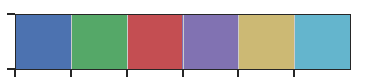

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from matplotlib.mlab import griddata
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import mpmath as mp
import scipy as sci
import scipy.special as special
import scipy.constants as const
import scipy.optimize as optimize
import seaborn as sns
sns.set(font_scale = 2)
#sns.set_style("ticks")
# Customizations
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rc('font', family='DejaVu Sans')
#mpl.rc('font', weight='bold')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
#Customizations
#import matplotlib as mpl
# mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage[version=4]{mhchem}',# chemical reactions
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath',               # <- tricky! -- gotta actually tell tex to use!
       r'\usepackage{textgreek}'
] 
from IPython.display import display, Math, Latex
import dynamic_charging as dyn
current_palette = sns.color_palette()
sns.set_style("whitegrid", {'axes.linewidth': '1', 'axes.edgecolor': '0.15',
                            "xtick.major.size": 8, "ytick.major.size": 8,
                            "xtick.minor.size": 4, "ytick.minor.size": 4})
sns.palplot(current_palette)
plt.show()

In [3]:
class MinorSymLogLocator(mtick.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the upper end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))


In [4]:
Temperature = 300.0# Particle temperature in Kelvin
KT = const.Boltzmann*Temperature
rho = 2.328*(1e-3/1e-6)# g/cm3 -> Kg/m3
pi = const.pi
eps0 = const.epsilon_0
echarge = const.elementary_charge
Ke = 1.0/(4.0*pi*eps0)
#Epsilon = 11.68
pressure_torr = 0.1
pressure = pressure_torr * 133.322
ng_num = pressure / KT
ng_num

3.2188255028634426e+21

# Plasma parameters

We will assume that the plasma will not be affected by the nanoparticles. We pose the following conditions~\cite{mamunuru_existence_2017},

| Parameter | Value   |
|------|------|
| Pressure ($p$)| 0.1 Torr|
| Argon ion density ($n_+$) | 10<sup>15</sup> m<sup>-3</sup>|
| Electron density ($n_e$) | 9.x10<sup>14</sup> m<sup>-3</sup>|
| Electron mean energy ($\varepsilon$) | 3 eV|
| Gas/ion/nanoparticle temperature ($T$) | 300 K |
| Gas density ($n_g$) | 3.x10<sup>21</sup> m<sup>-3</sup>|
| Argon mass ($m_+$) | 6.63x10<sup>-26</sup> Kg|

Also, we are assuming that the reactor, ions and nanoparticles have the same temperature, which is not true.

# Note: 
\begin{equation}
    \varepsilon = k T_e
\end{equation}

In [5]:
etemp = 3.# in eV
emean = etemp# Electron mean energy
electron_density = 9.0E14# electron density
#electron_density = 7.E14# electron density
ion_density = 1.0E15# electron and ion density
#ion_density = 7.E14# electron and ion density
# constants
pi = np.pi
Ke = 1.0/(4.0*pi*const.epsilon_0)
echarge = const.elementary_charge
ArMMass = 39.948 #Argon Molecular Mass (NIST) in g/mol
ArMass = (ArMMass / const.Avogadro)/1000.0 #Argon Mass in Kg

# Si nanoparticles

For the Si nanoparticles we have,

| Parameter | Value   |
|------|------|
| Nanoparticle density ($N$) | 10<sup>14</sup> m<sup>-3</sup>|
| Dielectric constant ($\epsilon$) | 11.68 |
| Mass density ($\mu$) | 2.328<sup>3</sup> Kg/m<sup>3</sup> |
| Electron affinity ($E_A$) | 4.05 |


We consider the following nanoparticle parameters for volume sections:

| Parameter | Value   |
|------|------|
| Number of sections ($l$) | 50 |
| Minimum diameter ($d_0$) | 1 nm |
| Maximum diameter ($d_l$) | 100 nm |
| Base ($b$) | 1.32572 |

The subsequents volume sections are calculated from:
\begin{equation}
v_{i+1} = v_0 b^{i} \qquad v_{i+i} = v_i b
\end{equation}

In [6]:
#Si_density = 2.328 * 1e3# g/cm3 to kg/m3 
Si_affinity = 4.05# Le Picard
Epsilon_Si = 11.68

In [7]:
NP_density = 1e14
#NP_density = 0.1e14

In [8]:
electron_density+NP_density-ion_density

0.0

In [9]:
def radfromvol(v):
    ''' Computes radius from a given volume
    '''
    return (3.0 * v/(4.0*np.pi))**(1/3)
def volfromrad(r):
    ''' Computes volume from a given radius
    '''
    return (4.0/3.0) * np.pi * (r)**3

lsec = 50# 50 sections
base = 1.32572#
iface_r0 = 0.5E-9# lower value of first section
iface_vol0 = volfromrad(iface_r0)# lowest volume
# compute interfaces
ifaces = np.array([iface_vol0*base**(i) for i in np.arange(lsec+1)])

def amean_pivots(ifaces):
    ''' Compute pivot
    '''
    return 0.5*(ifaces[:-1]+ifaces[1:])

# volume pivots
vpivots = amean_pivots(ifaces)

# compute radii and diameters
radii = radfromvol(vpivots)
diams = 2.0 * radii

## Mean free path

\begin{equation} 
    \lambda = \frac {1}{{\sqrt {2}}N_p \pi d^{2}}
    %\lambda = \frac {\kboltz T}{{\sqrt {2}}\pi d^{2}p}
\end{equation}

In [10]:
def mean_free_path(density, diameter):
    ''' Returns the mean free path for a given density and diameter
    '''
    return 1/(np.sqrt(2)*density*np.pi*diameter**2)

In [11]:
mean_free_paths = mean_free_path(NP_density, diams)

In [12]:
mean_free_paths.max()

2035.4018965525315

In [13]:
mean_free_paths.min()*1000

203.49688933939439

## Dusty Debye length

\begin{equation}
 \lambda_{e, i, p} = \sqrt{\frac {\varepsilon_{0}\kboltz T_{e, i, p}}
                             {n_{e, i, p}q_{e}^{2}}}
\end{equation}


\begin{equation}
 \frac{1}{\lambda_{\text{D}}^2} = \frac{1}{\lambda_{\text{e}}^2}
         + \frac{1}{\lambda_{\text{i}}^2}
\end{equation}


In [14]:
def dusty_debye_length(mean_electron_energy, electron_density,
                       ion_temperature, ion_density, nanoparticle_density):
    ''' Returns the Dusty Debye Length (Shukla), Dusty Debye Length,
        electron Debye length and ion Debye length
    '''
    #kboltz_ev = const.physical_constants['Boltzmann constant in eV/K'][0]
    #electron_temperature = mean_electron_energy/kboltz_ev
    electron_temperature = mean_electron_energy
    
    electron_debye_length = np.sqrt(electron_temperature*const.electron_volt
                                    *const.epsilon_0
                             /(electron_density*echarge**2))
    
    ion_debye_length = np.sqrt(const.Boltzmann*ion_temperature
                               *const.epsilon_0
                               /(ion_density*echarge**2))
    
    dusty_debye = np.sqrt(const.Boltzmann*ion_temperature
                          *const.epsilon_0
                          /(nanoparticle_density*echarge**2))
    
    dusty_debye_length_ = 1.0/np.sqrt(1./electron_debye_length**2
                                      +1./ion_debye_length**2)
    dusty_debye_length2_ = 1.0/np.sqrt(1./electron_debye_length**2
                                      +1./ion_debye_length**2
                                      +1./dusty_debye**2)
    
    return dusty_debye_length_, dusty_debye_length2_, electron_debye_length, ion_debye_length

In [15]:
ddl, ddl2, edebye, idebye = dusty_debye_length(emean, electron_density,
                                               Temperature, ion_density, NP_density)

In [16]:
ddl

3.7652044093399767e-05

In [17]:
ddl2

3.5912380307916382e-05

In [18]:
edebye

0.00042919884306290957

In [19]:
idebye

3.7797769138743015e-05

## Interparticle distance

\begin{equation}
 d = \left({\frac {3}{4\pi n}}\right)^{1/3}
\end{equation}

In [20]:
def interparticle_distance(density):
    ''' Returns the interparticle distance
    '''
    return np.cbrt(3.0/(4.0*np.pi*density))

In [21]:
idistance = interparticle_distance(NP_density)

In [22]:
print(idistance)

1.33650461757e-05


## Structure parameter

In [23]:
structure_parameter = idistance/ddl

In [24]:
structure_parameter

0.35496203453300934

## Knudsen number

\begin{equation}
  \text{Kn} = \frac{\lambda}{d_p}
\end{equation}

In [25]:
kn = mean_free_paths/diams

In [26]:
kn.min()

1934947.1066276876

In [27]:
kn.max()

1935564720080.4543

## Coupling parameter

\begin{equation}
  \Gamma = \frac{1}{4\pi \eps_0}\frac{Z^2 e^2}{\kboltz T_p d}\exp(-\kappa_\text{d})
\end{equation}

In [28]:
def coupling_parameter(nanoparticle_charge, interparticle_distance, structure_parameter):
    ''' Returns the coupling parameter
    '''
    num = nanoparticle_charge**2*echarge**2
    denom = 4.*np.pi*const.epsilon_0*KT*interparticle_distance
    return np.exp(-structure_parameter)*num/denom

In [29]:
gamma = coupling_parameter(np.arange(1, 296), idistance, structure_parameter)

In [30]:
np.exp(-structure_parameter)

0.70120006409111924

In [31]:
echarge

1.6021766208e-19

In [32]:
gamma.max()

254.31578397339126

In [33]:
gamma.min()

0.0029223301806767161

In [34]:
gamma[-1]

254.31578397339126

In [35]:
gamma[-60]

162.76210174297037

In [36]:
coupling_parameter(243, idistance, structure_parameter)

172.56067483877942

# Coagulation rate

The coagulation kernel for neutral particles in the free molecular regime is written as, 

\begin{equation}
\beta^{0}_{ij} = \left(\frac{3}{4\pi}\right)^{1/6}
                 \left[\frac{6 \kboltz T}{\rho_p}\left(\frac{1}{v_i}+\frac{1}{v_j} \right)\right]^{1/2}
                 \left(v^{1/3}_i + v^{1/3}_j \right)^2,
\end{equation}

where $v_{i}(v_{j})$ represents the volume of particle $i(j)$,  $\kboltz$ is the Boltzmann constant, $T$ is the
absolute temperature of the reactor, and  $\rho_{p}$ is the particle mass density.

In [37]:
def beta_free(vol1, vol2, temp=Temperature, rho=rho):
    ''' Coagulation rate in the free molecular regime
    '''   
    beta0 = (3.0/(4.0*np.pi))**(1/6)*np.sqrt(6.0*const.Boltzmann *temp/rho)
    return beta0 * np.sqrt(1.0/vol1 +1.0/vol2) * (vol1**(1.0/3.0)+vol2**(1.0/3.0))**2

In [38]:
radii_cr = np.linspace(0.5, 50.0, 500,endpoint=True)*1e-9

In [39]:
volumes_cr = volfromrad(radii_cr)

In [40]:
rx, ry = np.meshgrid(radii_cr*1e9, radii_cr*1e9)
dx, dy = 2.0*rx, 2.0*ry
vx, vy = np.meshgrid(volumes_cr, volumes_cr)

In [41]:
bf = beta_free(vx, vy)

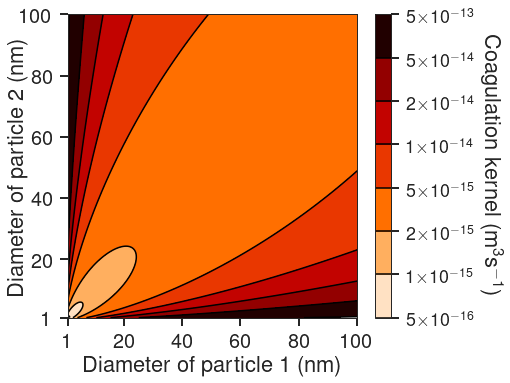

In [42]:
fig, ax = plt.subplots(figsize=(7.5, 5.85))

levels = [5e-16, 1e-15, 2e-15, 5e-15, 1e-14, 2e-14, 5e-14, 5e-13]
cf = ax.contourf(dx, dy, bf, levels=levels, cmap=cm.gist_heat_r,  norm=colors.LogNorm(),
                 vmin=levels[0], vmax=levels[-1])
cs = ax.contour(dx, dy, bf, levels=levels, origin='lower',
                colors='k', linewidths=1.5)
cb = fig.colorbar(cf, ax=ax, ticks=levels)
cb.add_lines(cs)
cb.ax.set_ylabel(r'Coagulation kernel $(\text{m}^3\text{s}^{-1})$', rotation=270, labelpad=30)
cb.ax.tick_params(labelsize=18)

ax.set_xlabel('Diameter of particle 1 (nm)')
ax.set_ylabel('Diameter of particle 2 (nm)', labelpad=-8)
xy=np.arange(0, 120, 20)
xy[0] = 1
plt.xticks(xy, xy)
plt.yticks(xy, xy)

cb.set_ticks(levels)
cb.set_ticklabels([r'$5{\times}10^{-16}$', r'$1{\times}10^{-15}$', r'$2{\times}10^{-15}$', r'$5{\times}10^{-15}$',
                   r'$1{\times}10^{-14}$', r'$2{\times}10^{-14}$', r'$5{\times}10^{-14}$', r'$5{\times}10^{-13}$'])

plt.tight_layout()
plt.savefig('fig1.eps')
plt.show()

In [43]:
np.max(bf)

7.4527112871196548e-13

In [44]:
np.min(bf)

4.1328183938190095e-16

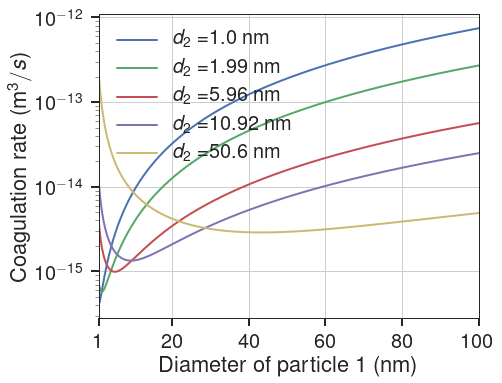

In [45]:
fig, ax = plt.subplots(figsize=(7.5, 5.85))

dlist = [0, 5, 25, 50, 250]
for i, di in enumerate(dlist):
    label = r'$d_2=$'+str(np.around(dx[di][di], decimals=2))+' nm'
    plt.plot(dx[di], bf[di], label=label)


xy=np.arange(0, 120, 20)
xy[0] = 1
plt.xticks(xy, xy)
ax.set_xlabel(r'Diameter of particle 1 (nm)')
ax.set_ylabel(r'Coagulation rate $(\text{m}^3/s)$')
ax.set_yscale('log')
plt.xlim([1, 100])
plt.legend(loc=2)
plt.tight_layout()
#plt.savefig('fig1.eps')
plt.show()

# Collision frequencies

The OML collision frequencies are:
    \begin{equation*}
      \nu_{j(i,k)}= 4\pi r^2_i n_j \left( \frac{E_j}{2\pi m_j}\right)^{1/2}\alpha_j,
    \end{equation*}
where $r_i$ is the radius of nanoparticle $i$ with charge number $k$, $j$ represents the index for plasma species and $n_j$, $E_j$ and $m_j$ are the density, energy and mass for plasma species $j=e, Ar^+$ with charge number $z_j$. The coefficient
$\alpha_j$ and the nanoparticle potential are defined by:
     \begin{align*}
      \alpha_j &= \left \{
      \begin{array}{ll}
       \exp\left(-\frac{z_j e\phi_{i,k}}{k_B T_j} \right) & \quad\textrm{for } z_j k\geq 0  \\
       \exp\left(1-\frac{z_j e\phi_{i,k}}{k_B T_j} \right) & \quad\textrm{for } z_j k < 0
      \end{array} \right .\\
      \phi_{i,k}&=\frac{ke}{4\pi\varepsilon_{0}r_i}.
     \end{align*}
For instance $E_e = \varepsilon$, i.e., electron mean energy. In the case of argon ions we approximate $E_\text{ion} \sim k_B T$, it means that we are neglecting the kinetic energy of the ions.

In [46]:
def phid(q, radii):
    ''' Computes the nanoparticle potential
    '''
    return Ke*q*const.elementary_charge/radii

def ecollfreq(q, radii, electron_density, emean_ev):
    ''' Computes the electron collision frequency
    '''
    emean = emean_ev * const.electron_volt    
    kte = emean
    radii2 = radii**2
    efreqfactor = 4. * pi * radii2 * electron_density * np.sqrt(kte/(2.*pi*const.electron_mass))
    if q <0.0 :
        return efreqfactor * np.exp(const.elementary_charge * phid(q, radii)/kte)
    else :
        if q >0.0 :
            return efreqfactor * (1.0 + const.elementary_charge*phid(q, radii)/kte)
        else :
            return efreqfactor

def icollfreq(q, radii, ion_density, temp):
    ''' Computes the ion collision frequency
    '''
    kti = const.k * temp
    radii2 = radii**2
    ifreqfactor = 4. * pi * radii2 * ion_density * np.sqrt(kti/(2.*pi*ArMass))
    if q>0.0 :
        return ifreqfactor * np.exp(-const.elementary_charge * phid(q, radii)/kti)
    else :
        if q<0.0 :
            return ifreqfactor * (1.0 - const.elementary_charge*phid(q, radii)/kti)
        else :
            return ifreqfactor

# Tunneling limit

In [47]:
invKe = 4.0*np.pi*const.epsilon_0

def particle_potenergy(r, Z):
    return -(Ke*Z*const.elementary_charge**2)/r

In [48]:
def rt_affinity(R, Z, ainfinity=Si_affinity*const.electron_volt):
    """ Computes rt r_t = \frac{Z}{\frac{Z}{R}+ A_\infty\frac{4\pi\varepsilon_0}{e^2} - \frac{5}{8}\frac{1}{R}}
    """
    ai = ainfinity * invKe/const.elementary_charge**2
    rt = Z/(Z/R + ai - (5/(8*R)))
    if rt < 0:
        return 1000000
    else:
        return rt

In [49]:
def tunnel(rt, R, Z):
    """ Griffiths Introduction to quantum mechanics The WKB approximation
        pp 295-297 eq8.24
    """
    prefac1 = -2./const.hbar
    prefac2 = np.sqrt(2.*const.electron_mass*particle_potenergy(rt, Z))
    return np.exp(prefac1*prefac2*(rt*np.arccos(np.sqrt(R/rt))-np.sqrt(R*(rt-R))))

In [50]:
def ptunnel(Z, R, temperature, ainfinity=Si_affinity*const.electron_volt):
    prefac1 = (-Z)*np.sqrt(2.*const.Boltzmann*temperature/const.electron_mass)*(0.5/R)
    rt = rt_affinity(R, Z, ainfinity)
    return prefac1*tunnel(rt, R, Z)

# charge limit from tunneling

In [51]:
def balance_oml(Z, R, electron_density, ion_density, emean, temperature):
    #return ptunnel(Z, R, temperature, ainfinity)
    return icollfreq(Z, R, ion_density, temperature)-ecollfreq(Z, R, electron_density, emean)

In [52]:
def balance_tunnelectron(Z, R, electron_density, emean, temperature, ainfinity=Si_affinity*const.electron_volt):
    if Z<0:
        welec=1.0
    return welec*ptunnel(Z, R, temperature, ainfinity)-ecollfreq(Z, R, electron_density, emean)

In [53]:
mradii = np.linspace(0.5, 50, 300)*1e-9
mdiams = 2.0*mradii
qmax_balance_oml = np.zeros_like(mradii)
qmax_balance_tunnel = np.zeros_like(mradii)
ap_tunnel = np.zeros_like(mradii)
for j, r in enumerate(mradii): 
    #print(r)
    #ap_tunnel[ind] = ptunnel(10, r, Temperature)
    qmax_balance_oml[j] = optimize.brentq(lambda q: balance_oml(q, r, electron_density, ion_density, emean, Temperature),
                                     -1e-7, -10e7, maxiter=10000)
    qmax_balance_tunnel[j] = optimize.brenth(lambda q: balance_tunnelectron(q, r, electron_density, emean, Temperature),
                                     -1e-7, -10e14, maxiter=100000, rtol=1e-15)

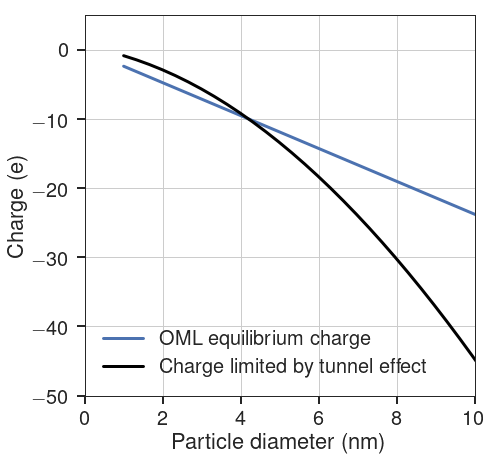

In [54]:
fig=plt.figure(figsize=(7,7))
plt.ylabel(r"Charge (e)")
plt.xlabel(r"Particle diameter (nm)")
#plt.yscale('symlog')
#plt.xscale('log')
plt.ylim([-50, 5])
plt.xlim([0, 10])
plt.plot(mdiams*1e9, (qmax_balance_oml), lw=3, label='OML equilibrium charge')
plt.plot(mdiams*1e9, (qmax_balance_tunnel), lw=3, label='Charge limited by tunnel effect', color='k')
#plt.bar(charges_nolim, tunnel_chargedist, alpha=0.5, label='dynamic', hatch='/', lw=1, ec='k', width=-1)#, align='center')
plt.legend()
plt.show()

In [55]:
np.abs(qmax_balance_oml-qmax_balance_tunnel).min()

0.19275604743688035

In [56]:
def sigma_variance(qmean, radii, emean_ev):
    ''' Computes the variance eq. 10 Le Picard
    '''
    emean = emean_ev * const.electron_volt
    #DANGER 3./2. FIXME
    #kte = (2./3.)*emean#*3./2.#* 2.0/3.0
    kte = emean*3./2.
    radii2 = radii**2
    
    ti = const.k * Temperature / const.elementary_charge
    
    prefactor = radii*kte/(Ke*const.elementary_charge**2)
    return prefactor * (1.0 - emean/(emean+ti-const.elementary_charge * phid(qmean, radii)))


In [57]:
# this is OML + Tunnel = 0, crossing above
dlim = 4.1e-9

In [58]:
mean_charge_oml = (qmax_balance_oml[mdiams>=dlim*0.9])# dlim x 0.9 to overlap 
mdiams_ex_limit = mdiams[mdiams>=dlim*0.9]*1e9

In [59]:
sigmas = np.sqrt(sigma_variance(mean_charge_oml, 0.5e-9*mdiams_ex_limit, emean))
two_sigmas = 2.0*np.sqrt(sigma_variance(mean_charge_oml, 0.5e-9*mdiams_ex_limit, emean))
three_sigmas = 3.0*np.sqrt(sigma_variance(mean_charge_oml, 0.5e-9*mdiams_ex_limit, emean))

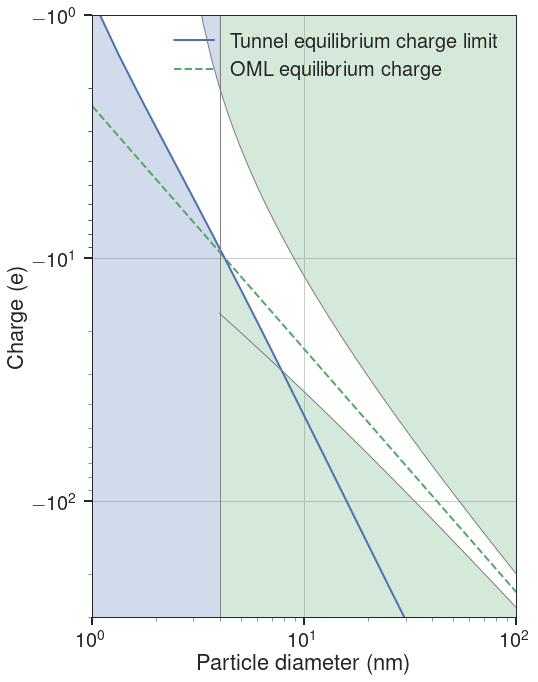

In [66]:
fig=plt.figure(figsize=(8, 10))
ax = fig.gca()
plt.ylabel(r"Charge (e)")
plt.xlabel("Particle diameter (nm)")

mdiams_in_limit = mdiams[mdiams<dlim]*1e9

charge_limit = (qmax_balance_tunnel[mdiams<dlim])
charge_balance_tunoml = (qmax_balance_tunnel[mdiams>=dlim*0.9])

clplot = plt.plot(mdiams_in_limit, charge_limit, lw=2, label='Tunnel equilibrium charge limit')
omlplot = plt.plot(mdiams_ex_limit, mean_charge_oml, '--',lw=2, label='OML equilibrium charge')

plt.plot(mdiams_in_limit, qmax_balance_oml[mdiams<dlim], '--',lw=2, color=omlplot[0].get_color())

plt.plot(mdiams_ex_limit, charge_balance_tunoml, color=clplot[0].get_color(), lw=2)#, label='Electron-tunnel current balance')

charge_limit_width = (qmax_balance_tunnel[mdiams<dlim])+7
charge_width_bottom = (qmax_balance_oml[mdiams>=dlim*0.9])-three_sigmas
charge_width_up = (qmax_balance_oml[mdiams>=dlim*0.9])+three_sigmas

three_sigmas_tun = 3.0*np.sqrt(sigma_variance(qmax_balance_oml[mdiams<dlim], 0.5e-9*mdiams_in_limit, emean))
charge_width_tun = (qmax_balance_oml[mdiams<dlim])+three_sigmas_tun

plt.plot(mdiams_ex_limit, charge_width_bottom, 'gray',lw=1)
plt.plot(mdiams_ex_limit, charge_width_up, 'gray',lw=1)

ax.fill_between(mdiams_in_limit, charge_limit, -1e3, alpha=0.25, color=current_palette[0])#, hatch="/")

ax.fill_between(mdiams_ex_limit, charge_balance_tunoml, charge_width_bottom,
                where= charge_balance_tunoml>=charge_width_bottom , alpha=0.25, color=current_palette[1])#, hatch="/")

ax.fill_between(mdiams_ex_limit, charge_width_bottom, -1e3, alpha=0.25, color=current_palette[1])#, hatch="/")
ax.fill_between(mdiams_ex_limit, charge_width_up, 1e3, alpha=0.25, color=current_palette[1])#, hatch="/")

plt.plot(mdiams_in_limit, charge_width_tun, 'gray',lw=1)
ax.fill_between(mdiams_in_limit, charge_width_tun, 1e3, alpha=0.25, color=current_palette[0])#, hatch="/")

iomltunnel = np.isclose(qmax_balance_oml, qmax_balance_tunnel, 1e-2)# when oml = tunnel
qpos = qmax_balance_oml[iomltunnel]
dpos = mdiams[iomltunnel]

plt.axvline(mdiams_in_limit[-1], ls='-', color='gray', lw=1)
plt.axvline(mdiams_ex_limit[0], ls='-', color='gray', lw=1)

plt.ylim([-300, -1])
plt.xlim([1, 100])
plt.xscale('log')
plt.legend(loc=0)
ax.set_yscale('symlog', linthreshy=1e-1)
yaxis = ax.yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
plt.tight_layout()
plt.savefig('fig2.pdf')
plt.show()

In [61]:
cross = np.abs(np.abs(charge_balance_tunoml)-np.abs(charge_width_bottom))

In [62]:
icross = np.argmin(cross)

In [63]:
dcross = mdiams_ex_limit[icross]

In [67]:
diams_tofile = np.concatenate((mdiams_in_limit, mdiams_ex_limit))
charge_tofile = np.concatenate((charge_limit, mean_charge_oml))

charge_up_tofile = np.concatenate((charge_width_tun, charge_width_up))
diams_bottom_tofile = np.concatenate((mdiams_ex_limit[mdiams_ex_limit<=dcross],mdiams_ex_limit[mdiams_ex_limit>=dcross]))

charge_bottom_tofile = np.concatenate((charge_balance_tunoml[mdiams_ex_limit<=dcross],
                                       charge_width_bottom[mdiams_ex_limit>=dcross]))

np.savez('probable_charge', diams_tofile=diams_tofile, charge_tofile=charge_tofile, charge_up_tofile=charge_up_tofile,
        diams_bottom_tofile=diams_bottom_tofile, charge_bottom_tofile=charge_bottom_tofile)

No handles with labels found to put in legend.


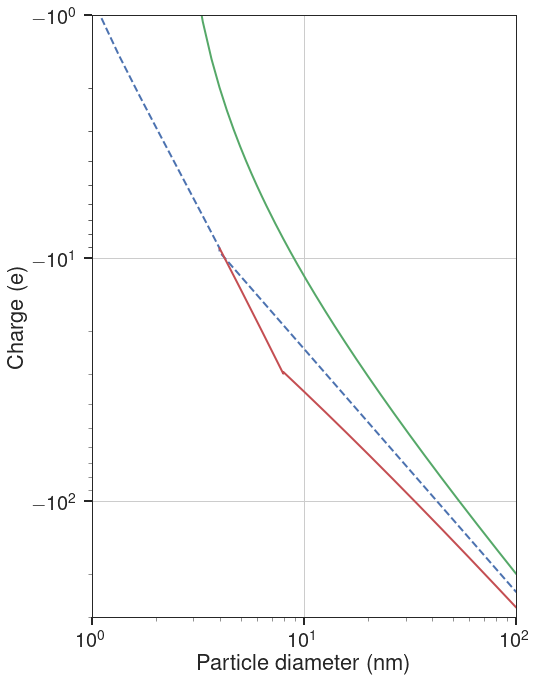

In [65]:
fig=plt.figure(figsize=(8, 10))
ax = fig.gca()
plt.ylabel(r"Charge (e)")
plt.xlabel("Particle diameter (nm)")

plt.plot(diams_tofile, charge_tofile, '--',lw=2)

plt.plot(diams_tofile, charge_up_tofile, lw=2)

plt.plot(diams_bottom_tofile, charge_bottom_tofile, '-',lw=2)
plt.ylim([-300, -1])
plt.xlim([1, 100])
plt.xscale('log')
plt.legend(loc=0)
ax.set_yscale('symlog', linthreshy=1e-1)
yaxis = ax.yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
plt.tight_layout()
#plt.savefig('fig2.pdf')
plt.show()

# Potentials and forces

## Description in terms of multipolar coefficients (PMC)

We need to solve the following linear system of A coefficients,
\begin{align}
A_{1,j_1} = Kq_1\delta_{j_1, 0} - \frac{\left( \varepsilon-1 \right)j_1}{\left( \varepsilon+1 \right)j_1+1}
\frac{r^{2j_1+1}_1}{r^{j_1+1}}Kq_2
+ \frac{\left( \varepsilon-1 \right)j_1}{\left( \varepsilon+1 \right)j_1+1}
\sum^{\infty}_{j_2=0} \sum^{\infty}_{j_3=0} \frac{\left( \varepsilon-1 \right)j_2}{\left( \varepsilon+1 \right)j_2+1}
\frac{\left(j_1+j_2\right)!}{j_1!j_2!}\frac{\left(j_2+j_3\right)!}{j_2!j_3!}
\frac{r^{2j_1+1}_1 r^{2j_2+1}_2}{r^{j_1+2j_2+j_3+2}}A_{1, j_3}
\end{align}

Then the potential energy is,

\begin{align}
\Phi_{\text{PMC}} &= K\frac{q_1q_2}{r}\\
&-\frac{q_1}{2}\sum^{\infty}_{m=1} \sum^{\infty}_{l=0}A_{1,l}\frac{\left(\varepsilon-1\right)m}{\left(\varepsilon+1\right)m+1}
\frac{\left(l+m\right)!}{l!m!}\frac{r^{2m+1}_2}{r^{2m+l+2}}
-\frac{1}{2K}  \sum^{\infty}_{l=1} A_{1,l}A_{1,l}\frac{\left(\varepsilon+1\right)l+1}
{\left(\varepsilon-1\right)lr^{2l+1}_1}
\end{align}

and the force is written as,

\begin{equation}
F_{\text{PMC}} = K\frac{q_1q_2}{r^2}
-q_1\sum^{\infty}_{m=1} \sum^{\infty}_{l=0}A_{1,l}\frac{\left(\varepsilon-1\right)m\left(m+1\right)}{\left(\varepsilon+1\right)m+1}
\frac{\left(l+m\right)!}{l!m!}\frac{r^{2m+1}_2}{r^{2m+l+3}}
-\frac{1}{K} \sum^{\infty}_{l=1}  A_{1,l}A_{1,l+1}\frac{\left(\varepsilon+1\right)\left(l+1\right)+1}{\left(\varepsilon-1\right)r^{2l+3}_
1}
\end{equation}

## Image potential approximation (IPA)

In the case that we can not neglect $r_2$ and $q_1\neq 0$, we could try to superpose the image potential energy of particle 1 in 2:

\begin{align}
\Phi_\text{IPA} = K\frac{q_1 q_2}{r}
-\left(\frac{\varepsilon-1}{\varepsilon+2}\right)\frac{K q^2_1 r^3_2}{2r^2\left( r^2-r^2_2\right)}
-\left(\frac{\varepsilon-1}{\varepsilon+2}\right)\frac{K q^2_2 r^3_1}{2r^2\left( r^2-r^2_1\right)}
\end{align}


\begin{align}
 F_\text{IPA}(r_2, q_1) &= -K q^2_1\left(\frac{\varepsilon-1}{\varepsilon+2}\right)\frac{r^3_2\left( 2r^2-r^2_2\right)}{r^3\left(r^2 - r^2_2\right)^2},\\
F_\text{IPA}(r_1, q_2) &= -K q^2_2\left(\frac{\varepsilon-1}{\varepsilon+2}\right)\frac{r^3_1\left( 2r^2-r^2_1\right)}{r^3\left(r^2 - r^2_1\right)^2},\\
F^\text{T}_\text{IPA} &= F_c + F_\text{IPA}(q_1, r_2) + F_\text{IPA}(q_1, r_2).
\end{align}

In [41]:
def potential_ipa_fact(rt, r21, q21, eps=Epsilon_Si):
    """ returns Potential Drain and Sutin (Point Charge Approximation) superposition
        function of rt = r/r1, r1, q1, r21=r2/r1, q21=q2/q1
    """

    kappa = (eps-1.0)/(eps+2.0)
    A = kappa*r21**3
    B = kappa*q21**2
    return q21/rt\
           - A/(2*rt**2*(rt**2 - r21**2))\
           - B/(2*rt**2*(rt**2 - 1.0))

def force_ipa_fact(rt, r21, q21, eps=Epsilon_Si):
    """ returns Force Drain and Sutin (Point Charge Approximation) superposition
    """

    kappa = (eps-1.0)/(eps+2.0)
    A = kappa*r21**3*(2.*rt**2-r21**2)
    B = kappa*q21**2*(2.*rt**2-1.)
    return q21/rt**2\
           - A/(rt**3*(rt**2 - r21**2)**2)\
           - B/(rt**3*(rt**2 - 1.0)**2)

In [42]:
def compute_Acoefficients(r1, q1, r2, q2, rn, eps=Epsilon_Si, j1max=5, j2max=5):
    ''' Solves the linear system for A coefficients
    '''
    j1n = np.arange(1, j1max)
    j2n = np.arange(1, j2max)
    j3n = np.arange(0, j1max)
    # A10 term, always positive. l=0
    A10 = Ke*q1
    #
    coefficients = np.zeros((len(j1n), len(j1n)))
    independent = np.zeros((len(j1n)))
    #
    count = 0
    for j1 in j1n:# from 1 to j1max
        #
        prefac1 = (eps-1.0)*j1/((eps+1.0)*j1 + 1.0)
        # term due to Q2, j1!=0, always negative
        f2 = -prefac1*r1**(2*j1+1)*Ke*q2/rn**(j1+1)
        # this term is independent of coefficients A
        independent[j1-1] = f2
        for j3 in j3n:# from 0 to j1max
            for j2 in j2n:# from 1 to j2max
                #print(j1,j2,j3)
                count +=1
                prefac2 = (eps-1.0)*j2/((eps+1.0)*j2 + 1.0)
                denom = (np.math.factorial(j1)*np.math.factorial(j2)*np.math.factorial(j2)*np.math.factorial(j3))*rn**(j1+2*j2+j3+2)
                numer = prefac1 * prefac2 * np.math.factorial(j1+j2)*np.math.factorial(j2+j3) * r1**(2*j1+1) * r2**(2*j2+1)
                if True:#np.abs(denom) > 1.0e-200 and np.abs(numer) < 1.0e200:
                    if j3!=0:
                        coefficients[j1-1][j3-1] -= numer / denom
                    else:# j3 == 0 => A10
                        independent[j1-1] += A10*numer / denom
            if j3==j1:
                coefficients[j1-1][j3-1] += 1.0
    #print(count)
    return coefficients, independent, A10

In [43]:
def force_mpc(r1, q1, r2, q2, h, acoeffs, eps=Epsilon_Si, f1=1.0, f2=1.0, f3=1.0):
    ''' As defined in equation 9 of 
        Lindgren, E. B., Chan, H.-K., Stace, A. J. & Besley, E.
        Progress in the theory of electrostatic interactions between charged particles.
        Phys. Chem. Chem. Phys. 18, 5883–5895 (2016).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    force_coul = Ke*q1*q2/h**2# Coulomb term
    #
    force_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*(m+1)*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+3)
            force_2 += numer / denom

    force_2 *= -q1

    force_3 = 0.0
    for l in lns[1:-1]:# l:1 -> lns-1
        numer = (acoeffs[l]*acoeffs[l+1])*((eps+1.0)*(l+1)+1)#2016
        denom = (eps-1.0)*r1**(2*l+3)        
        force_3 += numer / denom

    force_3 *= -invK

    return f1*force_coul + f2*force_2 + f3*force_3

In [44]:
def potential_mpc(r1, q1, r2, q2, h, acoeffs, eps=Epsilon_Si):
    ''' As defined in equation A7 of 
        Bichoutskaia, Elena et al.
        Electrostatic analysis of the interactions between charged particles of dielectric materials.
        The Journal of Chemical Physics 133, 024105 (2010).
        Note 1/2 factor to last two terms as in
        Stace, A. J. & Bichoutskaia, E. 
        Reply to the Comment on Treating highly charged carbon and fullerene clusters as dielectric particles
        by H. Zettergren and H. Cederquist, Phys. Chem. Chem. Phys., 2012, 14, DOI: 10.1039/c2cp42883k.
        Phys. Chem. Chem. Phys. 14, 16771–16772 (2012).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    pot_coul = Ke*q1*q2/h# Coulomb term
    #
    pot_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+2)
            pot_2 += numer / denom

    pot_2 *= -q1
#     print(pot_2)
    pot_3 = 0.0
    for l in lns[1:]:# l:1 -> lns-1
        numer = (acoeffs[l]*acoeffs[l])*((eps+1.0)*(l)+1)
        denom = (eps-1.0)*l*r1**(2*l+1)
        pot_3 += numer / denom

    pot_3 *= -invK

    # 1/2 factor to last two terms
    return pot_coul + 0.5*pot_2 + 0.5*pot_3

In [63]:
def plot_potentials_pmc_terms(ax, r1o, q1o, r2o, q2o, eps, rlimo):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)

    jterms = [25, 30, 35]
    ltlist = ['-', '--', ':']
    
    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 50)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for j, jvalue in enumerate(jterms):
        pot_b  = np.zeros_like(hl)
        for l, h in enumerate(hl): 
            As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=jvalue, j2max=jvalue)
            #Acs = np.linalg.solve(As, Fx)
            Acond = np.linalg.cond(As)
            if Acond > 1.5:
                count += 1
                print(Acond)
            if count > 20:
                return 0 
            Acs, res, rank, s = np.linalg.lstsq(As, Fx)
            acoeffs = np.append(A10, Acs)
            pot_b[l] = potential_mpc(r1, q1, r2, q2, h, acoeffs, eps=eps)

        sl = (hl*r1o-r1o-r2o)*1e9

        label = str(jvalue) + ' terms'
        plt.plot(hl*r1o*1e9, pot_prefactor*pot_b, lw=3, label=label, ls=ltlist[j])

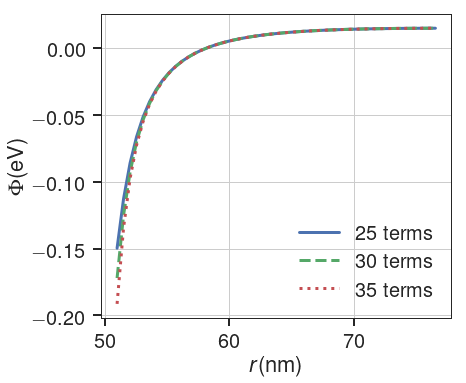

In [66]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 50.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
r2nm = np.array([1.0])
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*1.5

plot_potentials_pmc_terms(ax, r1, q1, r2m, q2, Epsilon_Si, rlim)

ax.set(xlabel=r'$r$(nm)', ylabel=r'\textPhi(eV)')

#plt.ylim([-0.10, 0.025])

plt.legend()
plt.tight_layout()
#plt.savefig('figB1.eps')
plt.show()


In [67]:
def plot_potentials_paper(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25, label=r"r", lt="--", cerror=False):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)

    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 250)
    pot_b  = np.zeros_like(hl)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_b[l] = potential_mpc(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e9
        

    # Plot IPA potential
    pot_ipa = potential_ipa_fact(hl, r2, np.abs(q2), eps=eps)*pot_prefactor*Ke
    pipa = ax.plot(hl*r1o*1e9, pot_ipa, label='IPA', zorder=1, lw=2, color='k')
    color = pipa[-1].get_color()

    plt.plot(hl*r1o*1e9, pot_prefactor*pot_b, '--', color='gray', zorder=2, lw=3, label='PMC')

    return pot_ipa, pot_prefactor*pot_b

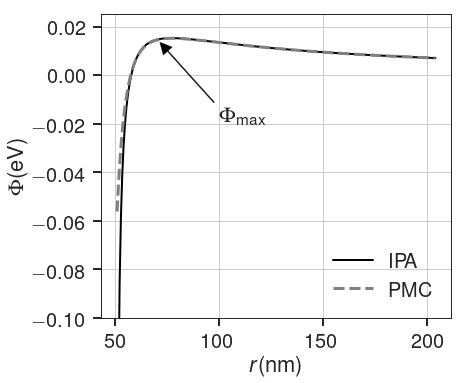

In [68]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 50.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([1.0])
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*4.0

phix=[plot_potentials_paper(ax, r1, q1, r2m, q2, Epsilon_Si, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.set(xlabel=r'$r$(nm)', ylabel=r'\textPhi(eV)')

plt.ylim([-0.10, 0.025])

ax.annotate(r'\textPhi$_\text{max}$', xy=(70, 0.015), xytext=(100, -0.02), size=22,
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            )
plt.legend()
plt.tight_layout()
plt.savefig('figB1.eps')
plt.show()

In [69]:
def plot_sweep_potential_0(r21array, q21array, eps, j1max=25, j2max=25):
    fig, ax = plt.subplots(figsize=(7, 5.85))
    
    rx, qy = np.meshgrid(r21array, q21array)
    
    pot_mpc = np.zeros([len(r21array), len(q21array)])
    pot_ipa = np.zeros_like(pot_mpc)
    
    h = 1.0 + r21array
    count = 0
    for ir, r21 in enumerate(r21array):
        for jq, q21 in enumerate(q21array):
            As, Fx, A10 = compute_Acoefficients(1.0, 1.0, r21, q21, h[ir], eps=eps, j1max=j1max, j2max=j2max)
            #Acs = np.linalg.solve(As, Fx)
            Acond = np.linalg.cond(As)
            if Acond > 1.5:
                count += 1
                print(Acond)
            #if count > 20:
            #    return 0 
            Acs, res, rank, s = np.linalg.lstsq(As, Fx)
            acoeffs = np.append(A10, Acs)
            pot_mpc[ir, jq] = potential_mpc(1.0, 1.0, r21, q21, h[ir], acoeffs, eps=eps)

    pot_ipa = potential_ipa_fact(1.0+rx, rx, qy, eps=eps)*Ke
    #levels = [5e-16, 1e-15, 2e-15, 5e-15, 1e-14, 2e-14, 5e-14, 5e-13]
#     cf = ax.contourf(rx, qy, pot_mpc, levels=levels, cmap=cm.gist_heat_r,  norm=colors.LogNorm())
    #cf = ax.contourf(rx, qy, pot_ipa, cmap=cm.gist_heat_r)
    cf = ax.contourf(rx, qy, pot_mpc.T, cmap=cm.gist_heat_r)
    plt.show()
    return rx, qy, pot_mpc.T, pot_ipa

In [70]:
#r21array = np.linspace(1, 50, 51)
#q21array = np.arange(0, 50)
r21array = np.linspace(1, 50, 100)
q21array = np.linspace(0, 50, 100)

In [71]:
len(q21array)

100

In [72]:
len(r21array)

100

2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.17354267049
2.1735

1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.65832625759
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.58995070189
1.5899

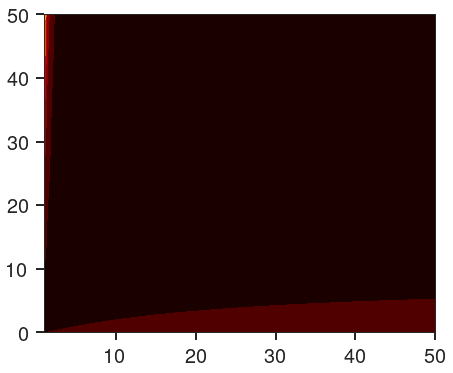

In [73]:
rx, qy, pot_mpc, pot_ipa = plot_sweep_potential_0(r21array, q21array, eps=Epsilon_Si, j1max=20, j2max=20)

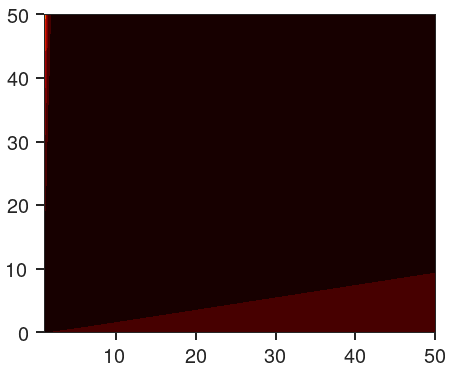

In [74]:
fig, ax = plt.subplots(figsize=(7, 5.85))
cf = ax.contourf(rx, qy, pot_ipa, cmap=cm.gist_heat_r)
plt.show()

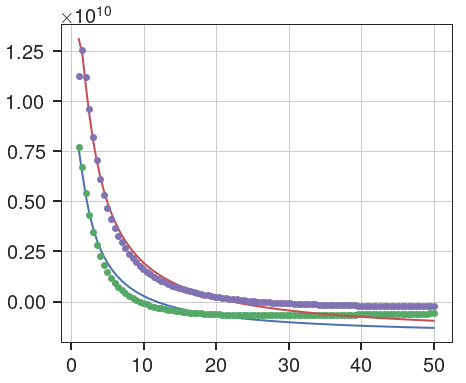

In [75]:
fig, ax = plt.subplots(figsize=(7, 5.85))
plt.plot(rx[0, :], pot_ipa[4, :])
plt.plot(rx[0, :], pot_mpc[4, :], 'o')
plt.plot(rx[0, :], pot_ipa[8, :])
plt.plot(rx[0, :], pot_mpc[8, :], 'o')
#plt.yscale('symlog')
plt.show()

In [76]:
pot_mpc.shape

(100, 100)

In [77]:
pot_ipa.shape

(100, 100)

In [78]:
def rel_error_pct(xexp, xreal):
    return 100.0*np.abs(xexp-xreal)/np.abs(xreal)

In [79]:
error = rel_error_pct(pot_ipa, pot_mpc)

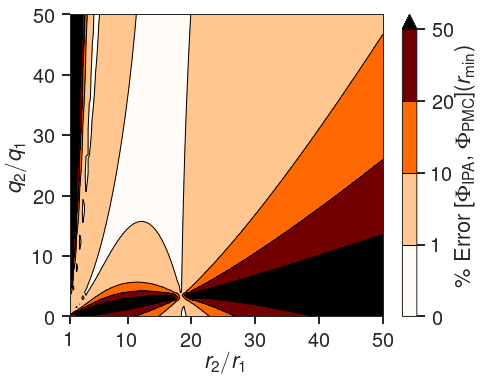

In [80]:
fig, ax = plt.subplots(figsize=(7.25, 5.85))
levels = [0, 1, 10, 20, 50]
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
csf = ax.contourf(rx, qy, error, levels=levels, origin='lower', cmap=cm.gist_heat_r, norm=norm, extend='max')
cs = ax.contour(rx, qy, error, levels=levels, origin='lower',
                        colors='k', linewidths=1.0)
cb = fig.colorbar(csf)
cb.add_lines(cs)
plt.ylabel(r"$q_2/q_1$")
plt.xlabel(r"$r_2/r_1$")
r21_labels = np.arange(0, 60, 10)
r21_labels[0] = 1
ax.set_xticks(r21_labels)
cb.ax.set_ylabel(r"\% Error [\textPhi$_\text{IPA}$, \textPhi$_\text{PMC}$]$(r_\text{min})$")#, rotation=270)
plt.tight_layout()
plt.savefig('figB2.eps')
plt.show()

In [81]:
error.max()

140583.45550090176

In [82]:
error.min()

0.0009297642234059318

In [83]:
def plot_sweep_potential_rt(r21array, q21array, eps, j1max=25, j2max=25):
    fig, ax = plt.subplots(figsize=(7, 5.85))
    
    rx, qy = np.meshgrid(r21array, q21array)
    
    pot_mpc = np.zeros([len(r21array), len(q21array)])
    pot_ipa = np.zeros_like(pot_mpc)
    rt = np.zeros_like(pot_mpc)
    no_rt = np.zeros_like(pot_mpc)
    pot_no_rt = np.zeros_like(pot_mpc)

    count = 0
    for ir, r21 in enumerate(r21array):
        for jq, q21 in enumerate(q21array):
            root = -1
            try:
                root = optimize.brentq(lambda h: force_ipa_fact(h, r21, q21, eps=eps),
                                       1+r21, 1e4*(1+r21), maxiter=10000)
                rt[jq, ir] = root
                As, Fx, A10 = compute_Acoefficients(1.0, 1.0, r21, q21, root, eps=eps, j1max=j1max, j2max=j2max)
                #Acs = np.linalg.solve(As, Fx)
                Acond = np.linalg.cond(As)
                if Acond > 1.5:
                    count += 1
                    print(Acond)
                #if count > 20:
                #    return 0 
                Acs, res, rank, s = np.linalg.lstsq(As, Fx)
                acoeffs = np.append(A10, Acs)
                pot_mpc[ir, jq] = potential_mpc(1.0, 1.0, r21, q21, root, acoeffs, eps=eps)
                pot_ipa[ir, jq] = potential_ipa_fact(root, r21, q21, eps=eps)*Ke
                pot_no_rt[ir, jq] = 1
            except :
                root = -1
                no_rt[ir, jq] = root
                pot_mpc[ir, jq] = root
                pot_ipa[ir, jq] = root
                pot_no_rt[ir, jq] = 0
                
                
    #levels = [5e-16, 1e-15, 2e-15, 5e-15, 1e-14, 2e-14, 5e-14, 5e-13]
#     cf = ax.contourf(rx, qy, pot_mpc, levels=levels, cmap=cm.gist_heat_r,  norm=colors.LogNorm())
    #cf = ax.contourf(rx, qy, pot_ipa, cmap=cm.gist_heat_r)
    cf = ax.contourf(rx, qy, pot_mpc.T, cmap=cm.gist_heat_r)
    plt.show()
    return rx, qy, rt, no_rt, pot_mpc.T, pot_ipa.T, pot_no_rt.T

1.86488957436
1.76706893472
1.86044590866
1.57943186765
1.70524245969
1.56046646577
1.58873875881
1.65014949888
1.55861230633
1.61015705861


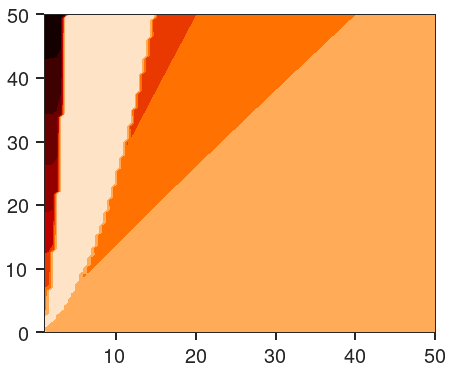

In [84]:
rx, qy, rt, no_rt, pot_mpc_rt, pot_ipa_rt, pot_no_rt = plot_sweep_potential_rt(r21array, q21array, eps=Epsilon_Si, j1max=20, j2max=20)

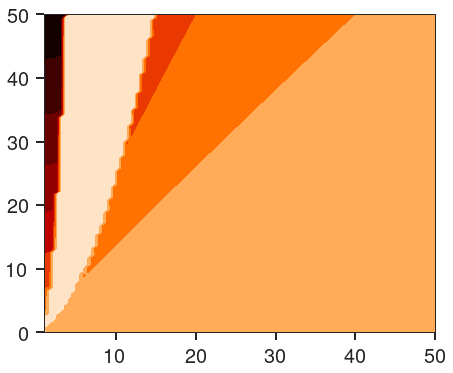

In [85]:
fig, ax = plt.subplots(figsize=(7, 5.85))
cf = ax.contourf(rx, qy, pot_ipa_rt, cmap=cm.gist_heat_r)
plt.show()

In [86]:
error_rt = rel_error_pct(pot_ipa_rt, pot_mpc_rt)

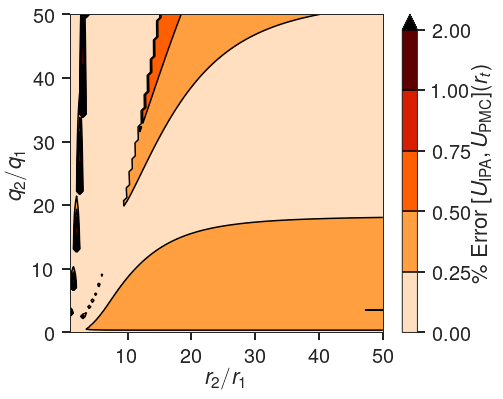

In [87]:
fig, ax = plt.subplots(figsize=(7, 5.85))
levels = [0, 0.25, 0.5, 0.75, 1, 2]
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
csf = ax.contourf(rx, qy, error_rt, levels=levels, origin='lower', cmap=cm.gist_heat_r, norm=norm, extend='max')
cs = ax.contour(rx, qy, error_rt, levels=levels, origin='lower',
                        colors='k', linewidths=1.5)
cb = fig.colorbar(csf)
cb.add_lines(cs)
plt.ylabel(r"$q_2/q_1$")
plt.xlabel(r"$r_2/r_1$")
cb.ax.set_ylabel(r"\% Error $[U_\text{IPA}, U_\text{PMC}](r_t)$")#, rotation=270)
plt.show()

In [88]:
pot_no_rt[pot_no_rt<0]=-10

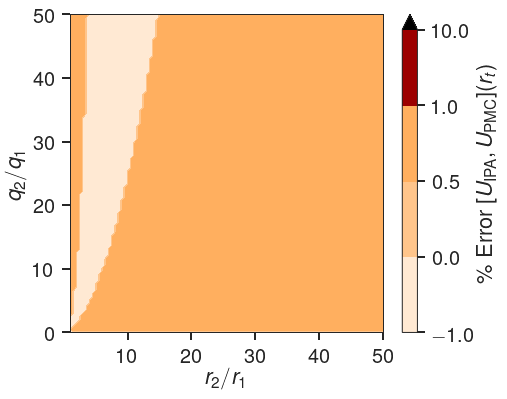

In [89]:
fig, ax = plt.subplots(figsize=(7, 5.85))
levels = [-1, 0, 0.5, 1, 10]
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
csf = ax.contourf(rx, qy, pot_no_rt, levels=levels, origin='lower', cmap=cm.gist_heat_r, norm=norm, extend='max')
# cs = ax.contour(rx, qy, error_rt, levels=levels, origin='lower', colors='k', linewidths=1.5)
cb = fig.colorbar(csf)
# cb.add_lines(cs)
plt.ylabel(r"$q_2/q_1$")
plt.xlabel(r"$r_2/r_1$")
cb.ax.set_ylabel(r"\% Error $[U_\text{IPA}, U_\text{PMC}](r_t)$")#, rotation=270)
plt.show()

In [90]:
cpot = np.copy(pot_no_rt)

In [91]:
cpot[cpot==0]=-1

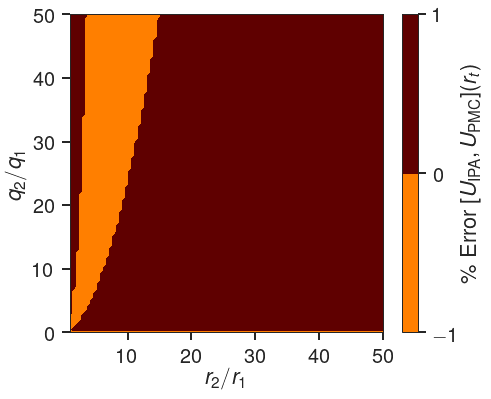

In [92]:
fig, ax = plt.subplots(figsize=(7, 5.85))
levels = [-1, 0, 1]
norm = mpl.colors.Normalize(vmin=levels[0], vmax=levels[-1])
csf = ax.contourf(rx, qy, cpot, levels=levels, origin='lower', cmap=cm.gist_heat_r, norm=norm)
# cs = ax.contour(rx, qy, error_rt, levels=levels, origin='lower', colors='k', linewidths=1.5)
cb = fig.colorbar(csf)
# cb.add_lines(cs)
plt.ylabel(r"$q_2/q_1$")
plt.xlabel(r"$r_2/r_1$")
cb.ax.set_ylabel(r"\% Error $[U_\text{IPA}, U_\text{PMC}](r_t)$")#, rotation=270)
plt.show()

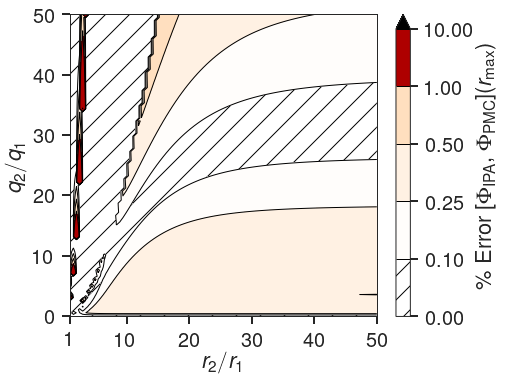

In [93]:
fig, ax = plt.subplots(figsize=(7.5, 5.85))
levels = [-1e-30, 0.1, 0.25, 0.5, 1.0, 10.0]
norm = mpl.colors.Normalize(vmin=levels[1], vmax=levels[-1])
hatches=['/', *[None]*(len(levels)-1)]
csf = ax.contourf(rx, qy, cpot*error_rt, levels=levels, origin='lower', cmap=cm.gist_heat_r,
                  norm=norm, extend='max', hatches=hatches)
cs = ax.contour(rx, qy, error_rt, levels=levels, origin='lower', colors='k', linewidths=1.0)
cb = fig.colorbar(csf)
cb.add_lines(cs)
plt.ylabel(r"$q_2/q_1$")
plt.xlabel(r"$r_2/r_1$")
r21_labels = np.arange(0, 60, 10)
r21_labels[0] = 1
ax.set_xticks(r21_labels)

plt.ylim([-1e-1,50])
plt.xlim([1,50])
cb.ax.set_ylabel(r"\% Error [\textPhi$_\text{IPA}$, \textPhi$_\text{PMC}$]$(r_\text{max})$")#, rotation=270)
plt.tight_layout()
plt.savefig('figB3.eps')
plt.show()

In [94]:
(cpot*error_rt).max()

11.532607127592806

In [95]:
error_rt.max()

11.532607127592806

In [96]:
error_rt.min()

0.0

In [97]:
q21array

array([  0.        ,   0.50505051,   1.01010101,   1.51515152,
         2.02020202,   2.52525253,   3.03030303,   3.53535354,
         4.04040404,   4.54545455,   5.05050505,   5.55555556,
         6.06060606,   6.56565657,   7.07070707,   7.57575758,
         8.08080808,   8.58585859,   9.09090909,   9.5959596 ,
        10.1010101 ,  10.60606061,  11.11111111,  11.61616162,
        12.12121212,  12.62626263,  13.13131313,  13.63636364,
        14.14141414,  14.64646465,  15.15151515,  15.65656566,
        16.16161616,  16.66666667,  17.17171717,  17.67676768,
        18.18181818,  18.68686869,  19.19191919,  19.6969697 ,
        20.2020202 ,  20.70707071,  21.21212121,  21.71717172,
        22.22222222,  22.72727273,  23.23232323,  23.73737374,
        24.24242424,  24.74747475,  25.25252525,  25.75757576,
        26.26262626,  26.76767677,  27.27272727,  27.77777778,
        28.28282828,  28.78787879,  29.29292929,  29.7979798 ,
        30.3030303 ,  30.80808081,  31.31313131,  31.81